In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2
from coherence_modeling import *

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Estimate coherence model parameters at SWiFT
from TTU tower data on 2013-11-08 to 09

General spatial coherence model from TurbSim, $Coh_{i,j}(f,r)$, depends on paramters $z_m$, $\bar{u}_m$, $a$, $b$, and $CohExp$.

Notes:
- Raj (stable BL) tested cd=10,20,30
- Raj's conclusion (stable BL): need larger value of coherence decrement (cd) to increase TKE near surface

## load data

In [4]:
%time df = pd.read_csv('data/TTU_tower_20131108_1Hz.csv',parse_dates=['datetime']).set_index('datetime')

CPU times: user 4 s, sys: 275 ms, total: 4.28 s
Wall time: 3.82 s


In [5]:
# sampling frequency of 1 Hz
fs = 1.0
df = df.pivot(columns='height').resample('1s').mean().stack().reset_index(1)

In [6]:
df.head()

,height,u,v,w,thetav
datetime,,,,,
2013-11-08,0.9,-0.247118,2.539655,0.047102,293.157128
2013-11-08,2.4,0.171599,3.076929,-0.136046,293.292080
2013-11-08,4.0,0.415578,4.078298,0.106247,293.558854
2013-11-08,10.1,-0.598401,4.993700,-0.138062,293.712662
2013-11-08,16.8,0.181203,5.545525,0.064441,293.895612


In [7]:
z = df['height'].unique() # [m]
z

array([  0.9,   2.4,   4. ,  10.1,  16.8,  47.3,  74.7, 116.5, 158.2,
       200. ])

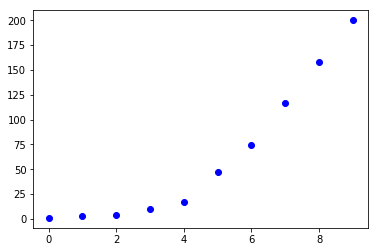

In [8]:
plt.plot(z,'bo')

In [9]:
df['speed'] = np.sqrt(df['u']**2 + df['v']**2 + df['w']**2)
df['direction'] = np.degrees(np.arctan2(-df['u'],-df['v']))
df.loc[df['direction'] < 0,'direction'] += 360.

In [10]:
stats_10min = df.pivot(columns='height',values=['speed','direction']).resample('10min').mean().stack()
stats_10min['variance'] = df.pivot(columns='height',values='speed').resample('10min').var().stack()
stats_10min['TI'] = 100 * np.sqrt(stats_10min['variance']) / stats_10min['speed']
stats_10min.reset_index(1,inplace=True)

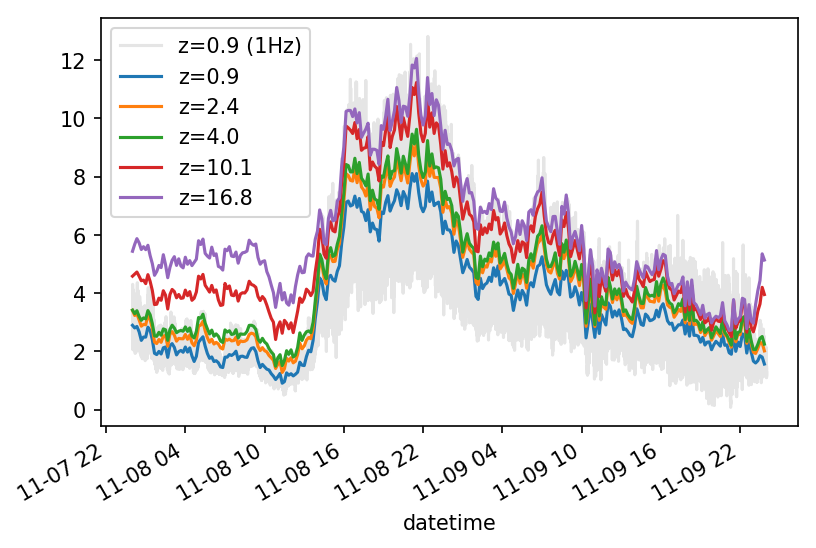

In [11]:
fig,ax = plt.subplots(figsize=(6,4),dpi=150)
series = df.loc[df['height']==z[0],'speed']
series.plot(ax=ax,color='k',alpha=0.1,label='z={:.1f} (1Hz)'.format(z[0]))
for i in range(5):
    stats_10min.loc[stats_10min['height']==z[i],'speed'].plot(ax=ax,label='z={:.1f}'.format(z[i]))
ax.legend()

## coherence function (TurbSim)

$Coh_{i,j}(f) = \frac{|S_{ij}(f)|}{\sqrt{S_{ii}(f)S_{jj}(f)}}$

$Coh = \exp \left( -a\left( \frac{r}{z_m} \right)^{CohExp} \sqrt{\left(\frac{f r}{\bar{u}_m\right)^2 + (b r)^2} \right)$

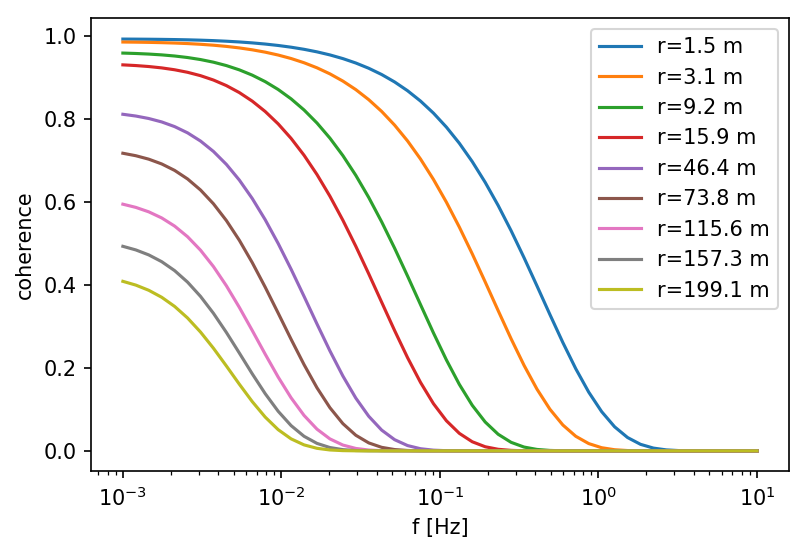

In [12]:
f = np.logspace(-3,1)
fig,ax = plt.subplots(figsize=(6,4),dpi=150)
for i in range(1,len(z)):
    r = z[i] - z[0]
    ax.semilogx(f,Coh_model(f,r),label='r={:.1f} m'.format(r))
ax.set_xlabel('f [Hz]')
ax.set_ylabel('coherence')
ax.legend()

## estimate coherence

In [13]:
tstart = '2013-11-08 10:00:00'
tend = '2013-11-08 13:00:00'
#selected = stats_10min.loc[(stats_10min.index >= tstart) & (stats_10min.index <= tend), ['height','speed']] 
selected = df.loc[(df.index >= tstart) & (df.index <= tend), ['height','speed']]

In [14]:
Umean = [
    selected.loc[selected['height']==zi,'speed'].mean() for zi in z
]

Text(0,0.5,'coherence')

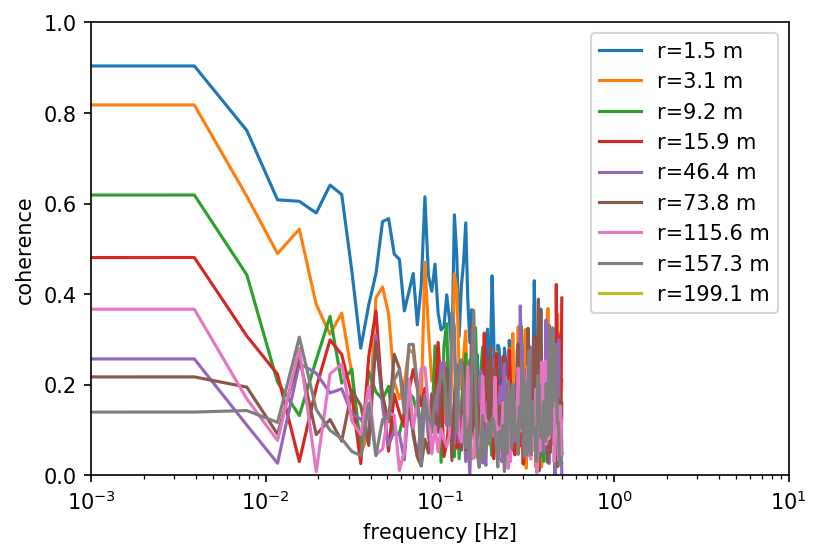

In [15]:
i0 = 0
#u1 = selected.loc[selected['height']==z[i0],'speed']
u1 = selected.loc[selected['height']==z[i0],'speed'].resample('2s').mean()
coh_ttu = []
r_ttu = []
for i in range(len(z)):
    if i==i0:
        continue
    #u2 = selected.loc[selected['height']==z[i],'speed']
    u2 = selected.loc[selected['height']==z[i],'speed'].resample('2s').mean()
    freq, Cxy = coherence(u1,u2,fs=fs)
    coh_ttu.append(np.sqrt(Cxy))
    r_ttu.append(z[i] - z[i0])

fig,ax = plt.subplots(figsize=(6,4),dpi=150)
isorted = np.argsort(np.abs(r_ttu))
for i in isorted:
    ax.semilogx(freq,coh_ttu[i],label='r={:.1f} m'.format(r_ttu[i]))
ax.set_xlim((1e-3,1e1))
ax.set_ylim((0,1))
ax.legend()
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('coherence')

## fit coherence model parameters

In [16]:
zhub = 74.7
Uhub = df.loc[(df.index >= tstart) & (df.index <= tend) & (df['height']==zhub), 'speed'].mean()
Uhub

10.408538128694692

0.9 36.35358745279211 0.011468373480678756
2.4 12.341062764118291 0.033664222802295515
4.0 3.062683115019044 0.05911545181035249
10.1 1.1255146724199134 0.1


Text(0.5,1,'Fit $a$ and $b$ (IEC model)')

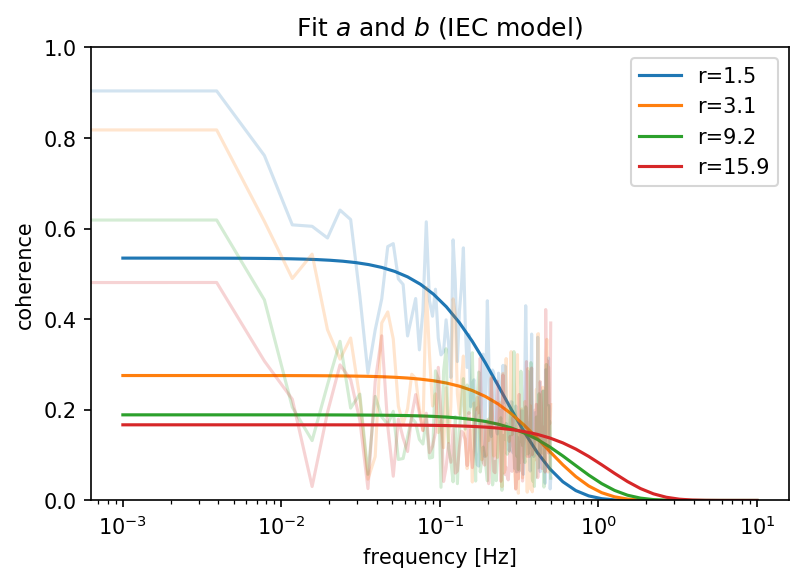

In [17]:
fig,ax = plt.subplots(figsize=(6,4),dpi=150)
for i in range(len(z)):
    if i >= 4:
        break
    ax.semilogx(freq,coh_ttu[i],alpha=0.2)
    a,b = fit_IEC(coh_ttu[i],freq,r_ttu[i],zref=zhub,Uref=Uhub)
    print(z[i],a,b)
    Coh_IEC_fit = Coh_model(f,r=r_ttu[i],zref=zhub,Uref=Uhub,a=a,b=b)
    plt.semilogx(f,Coh_IEC_fit,color=colors[i],label='r={:.1f}'.format(r_ttu[i]))
ax.set_ylim((0,1))
ax.legend()
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('coherence')
ax.set_title(r'Fit $a$ and $b$ (IEC model)')

0.9 92.11402154710399 0.0021814074479652866
2.4 114.36497381777515 0.0008137990172249366
4.0 46.584370295571546 0.0018418499635005103
10.1 12.720895429340786 0.006525359337851231


Text(0.5,1,'Weighted fit $a$ and $b$ (IEC model)')

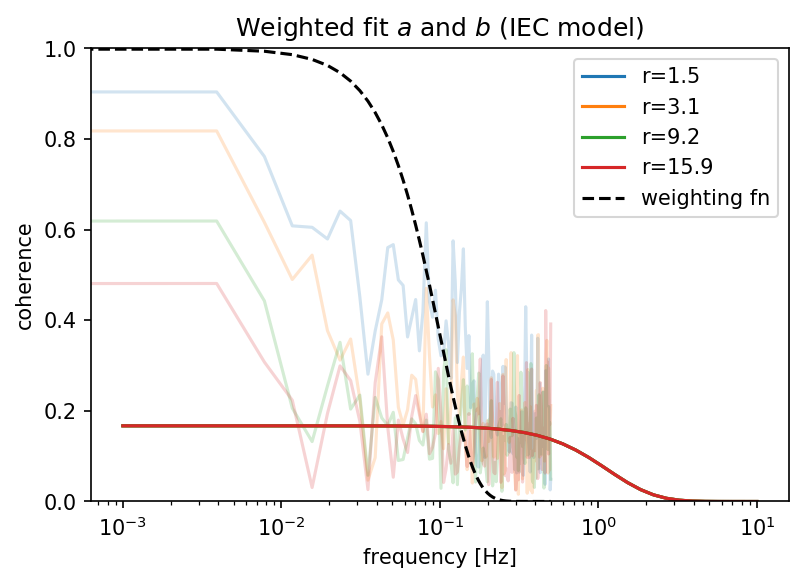

In [18]:
weight = 0.1
fig,ax = plt.subplots(figsize=(6,4),dpi=150)
for i in range(len(z)):
    if i >= 4:
        break
    ax.semilogx(freq,coh_ttu[i],alpha=0.2)
    a,b = fit_IEC(coh_ttu[i],freq,r_ttu[i],zref=zhub,Uref=Uhub,weighting=weight)
    print(z[i],a,b)
    Coh_IEC_fit_weighted = Coh_model(f,r=r_ttu[i],zref=zhub,Uref=Uhub,a=a,b=b)
    plt.semilogx(f,Coh_IEC_fit,color=colors[i],label='r={:.1f}'.format(r_ttu[i]))
ax.semilogx(freq,np.exp(-(freq/weight)**2),'k--',label='weighting fn')
ax.set_ylim((0,1))
ax.legend()
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('coherence')
ax.set_title(r'Weighted fit $a$ and $b$ (IEC model)')

0.9 4.345944679648148 0.0959205300981766 0.0002292965315097311 1.2444356711257938
2.4 3.100165994404394 0.09999999999999999 0.0005219197054479045 1.4949699256418105
4.0 0.10139917835110435 0.09999999999999999 1.9350380167334746 1.6149524416007814
10.1 0.8596668529360407 0.1 0.00851442723656842 2.1813822625440618


Text(0.5,1,'Fit $a$, $b$, $CohExp$ (general model)')

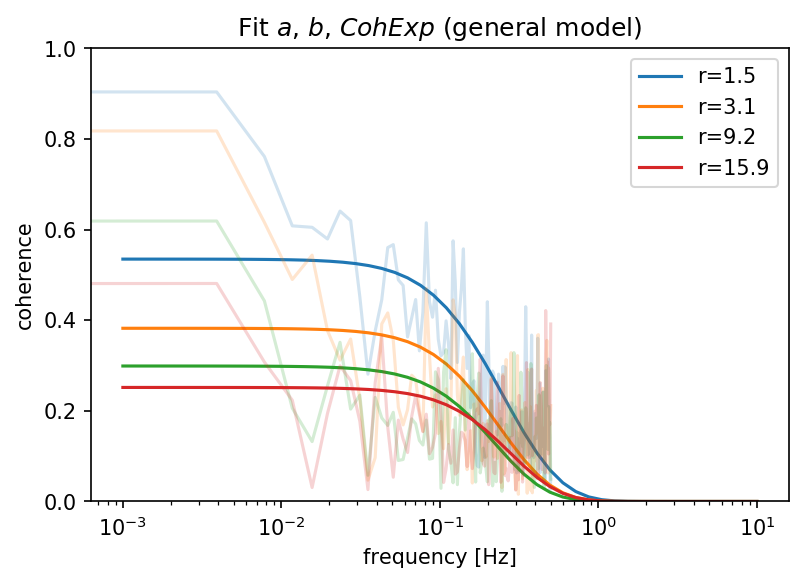

In [19]:
fig,ax = plt.subplots(figsize=(6,4),dpi=150)
for i in range(len(z)):
    if i >= 4:
        break
    ax.semilogx(freq,coh_ttu[i],alpha=0.2)
    zm = (z[i0] + z[i]) / 2
    Um = (Umean[i0] + Umean[i]) / 2
    a,b,exp = fit_general(coh_ttu[i],freq,r_ttu[i],zref=zm,Uref=Um)
    print(z[i],a,b,exp,Um)
    Coh_general_fit = Coh_model(f,r=r_ttu[i],zref=zm,Uref=Um,a=a,b=b,exp=exp)
    plt.semilogx(f,Coh_general_fit,color=colors[i],label='r={:.1f}'.format(r_ttu[i]))
ax.set_ylim((0,1))
ax.legend()
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('coherence')
ax.set_title(r'Fit $a$, $b$, $CohExp$ (general model)')

0.9 11.018322882155088 0.018206493678293717 0.0 1.2444356711257938
2.4 12.019050847602637 0.005660401885496003 0.4970196043378818 1.4949699256418105
4.0 7.2269366579695795 0.011861509707227822 0.0006142522468866112 1.6149524416007814
10.1 2.669966994875197 0.031058434731980788 0.0008703249023554272 2.1813822625440618


Text(0.5,1,'Weighted fit $a$, $b$, $CohExp$ (general model)')

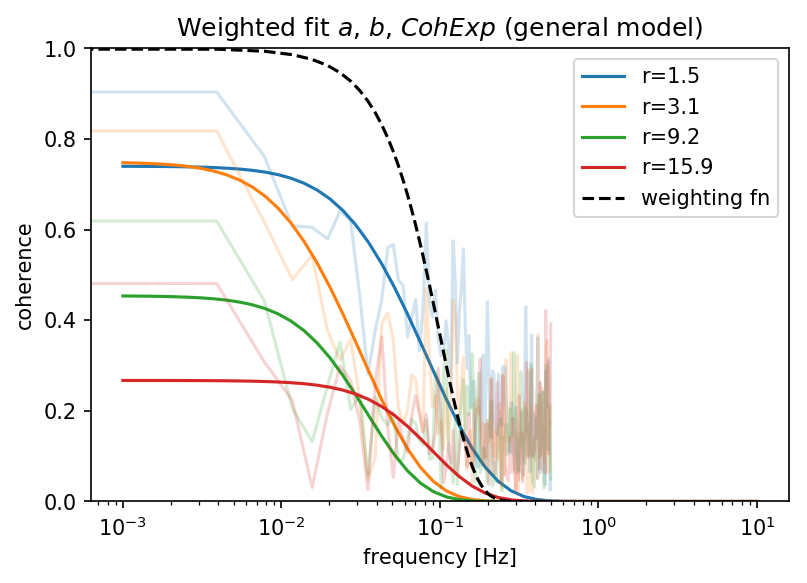

In [20]:
weight = 0.1
fig,ax = plt.subplots(figsize=(6,4),dpi=150)
for i in range(len(z)):
    if i >= 4:
        break
    ax.semilogx(freq,coh_ttu[i],alpha=0.2)
    zm = (z[i0] + z[i]) / 2
    Um = (Umean[i0] + Umean[i]) / 2
    a,b,exp = fit_general(coh_ttu[i],freq,r_ttu[i],zref=zm,Uref=Um,weighting=weight)
    print(z[i],a,b,exp,Um)
    Coh_general_fit_weighted = Coh_model(f,r=r_ttu[i],zref=zm,Uref=Um,a=a,b=b,exp=exp)
    ax.semilogx(f,Coh_general_fit_weighted,color=colors[i],label='r={:.1f}'.format(r_ttu[i]))
ax.semilogx(freq,np.exp(-(freq/weight)**2),'k--',label='weighting fn')
ax.set_ylim((0,1))
ax.legend()
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('coherence')
ax.set_title(r'Weighted fit $a$, $b$, $CohExp$ (general model)')

Text(0.5,1,'IEC model (a=100, b=0.001, u=10.4)')

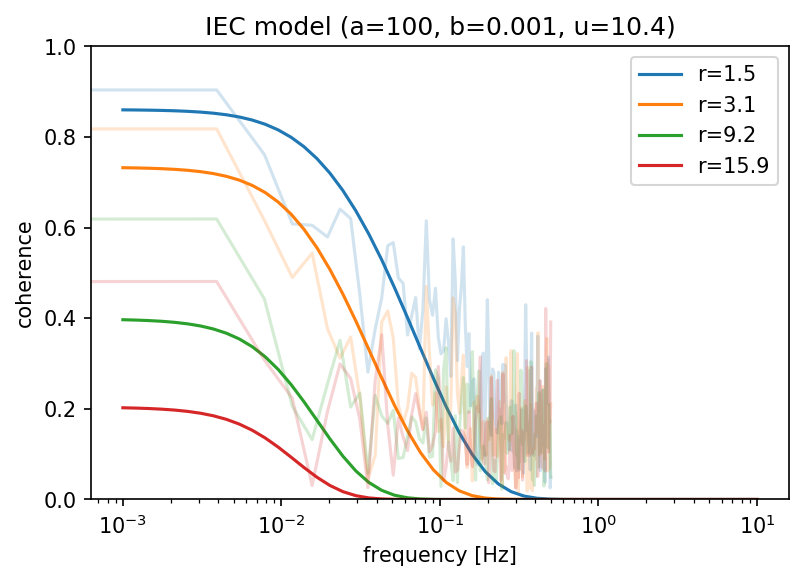

In [21]:
aopt = 100.
bopt = 1e-3
fig,ax = plt.subplots(figsize=(6,4),dpi=150)
for i in range(len(z)):
    if i >= 4:
        break
    ax.semilogx(freq,coh_ttu[i],alpha=0.2)
    zm = (z[i0] + z[i]) / 2
    Um = (Umean[i0] + Umean[i]) / 2
    Coh_IEC_opt = Coh_model(f,r=r_ttu[i],zref=zhub,Uref=Uhub,a=aopt,b=bopt,exp=0)
    ax.semilogx(f,Coh_IEC_opt,color=colors[i],label='r={:.1f}'.format(r_ttu[i]))
ax.set_ylim((0,1))
ax.legend()
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('coherence')
ax.set_title(r'IEC model (a={:g}, b={:g}, u=10.4)'.format(aopt,bopt))

Text(0.5,1,'General model (a=10, b=0.01, u=Um(z))')

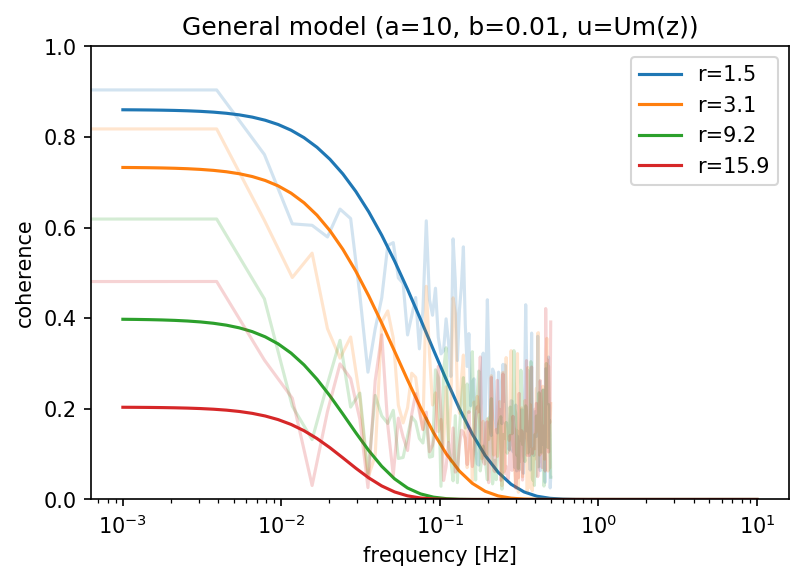

In [22]:
aopt = 10.
bopt = 1e-2
fig,ax = plt.subplots(figsize=(6,4),dpi=150)
for i in range(len(z)):
    if i >= 4:
        break
    ax.semilogx(freq,coh_ttu[i],alpha=0.2)
    zm = (z[i0] + z[i]) / 2
    Um = (Umean[i0] + Umean[i]) / 2
    Coh_general_opt = Coh_model(f,r=r_ttu[i],zref=zm,Uref=Um,a=aopt,b=bopt,exp=0)
    ax.semilogx(f,Coh_general_opt,color=colors[i],label='r={:.1f}'.format(r_ttu[i]))
ax.set_ylim((0,1))
ax.legend()
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('coherence')
ax.set_title(r'General model (a={:g}, b={:g}, u=Um(z))'.format(aopt,bopt))